# QAOA with Error Mitigation on IBM Quantum Hardware

**Professional implementation of QAOA for portfolio optimization with state-of-the-art error mitigation techniques.**

## Error Mitigation Techniques Implemented

This notebook implements 4 cutting-edge error mitigation methods:

1. **Zero-Noise Extrapolation (ZNE)**: Extrapolates results to zero-noise limit
2. **Readout Error Mitigation (REM)**: Corrects measurement bit-flip errors
3. **Dynamical Decoupling (DD)**: Inserts idle gates to suppress decoherence
4. **Probabilistic Error Cancellation (PEC)**: Inverts error channels probabilistically

Each technique can be enabled/disabled independently for ablation studies.

## Configuration

Set `ERROR_MITIGATION_CONFIG` to control which techniques are active:
- `zne=True`: Enable Zero-Noise Extrapolation
- `readout=True`: Enable Readout Error Mitigation  
- `dd=True`: Enable Dynamical Decoupling
- `pec=False`: Enable Probabilistic Error Cancellation (expensive)

---

In [1]:
# Core libraries
import numpy as np
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Qiskit core
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

# IBM Runtime
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    SamplerV2 as Sampler, 
    Options
)

# Transpilation and optimization
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.circuit.library import XGate, YGate

# Error mitigation (new Qiskit modules)
from qiskit_ibm_runtime.options import ResilienceOptionsV2

# Classical optimization
from scipy.optimize import minimize
from scipy.interpolate import interp1d

print("✓ All libraries imported successfully")
print(f"  Qiskit version: {__import__('qiskit').__version__}")

✓ All libraries imported successfully
  Qiskit version: 2.2.3


In [2]:
# ===================================================================
#                    CONFIGURATION PANEL
# ===================================================================

# BACKEND SELECTION: Set use_fake_backend=True for testing without IBM credentials
IBM_CONFIG = {
    'use_fake_backend': True,          # Toggle: True=Fake (testing), False=IBM Cloud
    'api_key': "your-token",
    #'instance': "crn:v1:bluemix:public:quantum-computing:...",
    'backend_name': None  # Auto-select least busy free-tier backend (ignored if use_fake_backend=True)
}

# QAOA parameters
QAOA_CONFIG = {
    'p_layers': 2,
    'shots': 3000,
    'max_iter': 40,
    'rhobeg': 0.5,
    'seed': 7
}

# Error Mitigation switches (MAIN CONTROLS)
ERROR_MITIGATION_CONFIG = {
    'zne': False,             # Disabled - circuit folding creates issues for own implementation. Sampling does not support this https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/options-zne-options
    'readout': False,          # Readout Error Mitigation ,  not supported in Sampling ??? please confirm??
    'dd': True,             
    'pec': False,             # Sampling does not support this https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/options-pec-options
    'twirling' : True           
}

# Advanced settings
ADVANCED_CONFIG = {
    'optimization_level': 3,   
    #'resilience_level': 1,     # IBM's built-in resilience (0-2)
    'dd_sequence': 'XY4',  # Dynamical decoupling sequence - XY4 now works with Y gate synthesis!
    'zne_noise_factors': [1, 2, 3],  # Noise amplification factors
    'final_shots': 8000        # High-quality shots for final result
}

print("="*60)
print("           QAOA WITH ERROR MITIGATION")
print("="*60)
print("\n📋 QAOA Config:")
for k, v in QAOA_CONFIG.items():
    print(f"  {k:15s}: {v}")

print("\n🛡️  Error Mitigation:")
for k, v in ERROR_MITIGATION_CONFIG.items():
    status = "✅ ENABLED" if v else "❌ DISABLED"
    print(f"  {k.upper():15s}: {status}")

total_techniques = sum(ERROR_MITIGATION_CONFIG.values())
print(f"\n  Active techniques: {total_techniques}/4")

# Backend mode
mode = "🧪 FAKE (Testing)" if IBM_CONFIG['use_fake_backend'] else "☁️ IBM QUANTUM (Real Hardware)"
print(f"\n  Backend Mode: {mode}")
print("="*60)

           QAOA WITH ERROR MITIGATION

📋 QAOA Config:
  p_layers       : 2
  shots          : 3000
  max_iter       : 40
  rhobeg         : 0.5
  seed           : 7

🛡️  Error Mitigation:
  ZNE            : ❌ DISABLED
  READOUT        : ❌ DISABLED
  DD             : ✅ ENABLED
  PEC            : ❌ DISABLED
  TWIRLING       : ✅ ENABLED

  Active techniques: 2/4

  Backend Mode: 🧪 FAKE (Testing)


In [3]:
print("\n🔗 Initializing backend...")

if IBM_CONFIG['use_fake_backend']:
    # ===== FAKE BACKEND (Testing Mode) =====
    from qiskit_ibm_runtime.fake_provider import FakeFez
    
    backend = FakeFez()
    print(f"✓ Using FAKE backend: {backend.name}")
    print(f"  🧪 Testing mode - No IBM Cloud credentials required")
    print(f"  Qubits: {backend.num_qubits}")
    print(f"  Basis gates: {backend.operation_names[:8]}...")
    
else:
    # ===== REAL IBM QUANTUM BACKEND =====
    service = QiskitRuntimeService(
        channel="ibm_quantum_platform",
        token=IBM_CONFIG['api_key'],
        #instance=IBM_CONFIG['instance']
    )

    if IBM_CONFIG['backend_name']:
        backend = service.backend(IBM_CONFIG['backend_name'])
    else:
        backend = service.least_busy(simulator=False, operational=True, min_num_qubits=21)

    print(f"✓ Connected to IBM Quantum: {backend.name}")
    print(f"  ☁️ Real hardware mode")
    print(f"  Qubits: {backend.num_qubits}")
    print(f"  Queue: {backend.status().pending_jobs} jobs")
    print(f"  Basis gates: {backend.operation_names[:8]}...")

    # Get backend properties for error mitigation
    try:
        target = backend.target
        print(f"  Error rates available: ✓")
    except:
        print(f"  Error rates available: ✗ (simulator)")


🔗 Initializing backend...
✓ Using FAKE backend: fake_fez
  🧪 Testing mode - No IBM Cloud credentials required
  Qubits: 156
  Basis gates: ['x', 'cz', 'switch_case', 'for_loop', 'sx', 'id', 'measure', 'if_else']...


In [4]:
data = np.load("portfolio_qubo_data.npz", allow_pickle=True)
Q = data['Q']
q = data['q']
mu = data['mu']
Sigma = data['Sigma']
B = int(data['B'])
TICKERS = list(data['TICKERS'])
n = len(TICKERS)

def qubo_to_ising(Q, q):
    n = len(q)
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)

print(f"\n✓ Portfolio data loaded:")
print(f"  Assets: {n}, Cardinality: {B}")
print(f"  Problem size: {n} qubits, {np.count_nonzero(J)} couplings")



✓ Portfolio data loaded:
  Assets: 21, Cardinality: 4
  Problem size: 21 qubits, 210 couplings


In [5]:
# Greedy-Sharpe initialization
sharpe_individual = mu / np.sqrt(np.diag(Sigma) + 1e-10)
sharpe_sorted = np.argsort(-sharpe_individual)
init_bits = np.zeros(n, dtype=int)
init_bits[sharpe_sorted[:B]] = 1

print(f"\n✓ Warm-start (Greedy-Sharpe):")
print(f"  Portfolio: {[TICKERS[i] for i in sharpe_sorted[:B]]}")
print(f"  Initial cost: {init_bits @ Q @ init_bits + q @ init_bits:.6f}")



✓ Warm-start (Greedy-Sharpe):
  Portfolio: [np.str_('JNJ'), np.str_('BRK-B'), np.str_('GOOGL'), np.str_('JPM')]
  Initial cost: -0.000946


In [6]:
def f_qubo(x: np.ndarray) -> float:
    """Compute QUBO objective value."""
    return float(x @ Q @ x + q @ x)

def bitarray_from_qiskit_string(s: str) -> np.ndarray:
    """Convert Qiskit bitstring to numpy array (little-endian)."""
    return np.array([int(c) for c in s[::-1]], dtype=int)

def is_valid(x: np.ndarray, B: int) -> bool:
    """Check cardinality constraint."""
    return np.sum(x) == B

def random_theta(size: int, rng: np.random.Generator) -> np.ndarray:
    """Generate random parameters."""
    return rng.uniform(0, 2*np.pi, size=size)


In [7]:
def build_qaoa_xy(n: int, P: int, J: np.ndarray, h: np.ndarray, 
                  init_bits: np.ndarray) -> Tuple[QuantumCircuit, List[Parameter]]:
    """
    Build QAOA ansatz with XY mixer for cardinality preservation.
    
    Parameters:
        n: Number of qubits
        P: Number of QAOA layers
        J: Coupling matrix (Ising)
        h: Local field vector (Ising)
        init_bits: Initial state (warm-start)
    
    Returns:
        qc: Quantum circuit
        params: List of Parameter objects
    """
    qc = QuantumCircuit(n, name="QAOA_XY")
    
    # Initialize to warm-start state
    for i, bit in enumerate(init_bits):
        if bit == 1:
            qc.x(i)
    
    # Create parameters
    gammas = [Parameter(f"γ{k}") for k in range(P)]
    betas = [Parameter(f"β{k}") for k in range(P)]
    
    # Ring topology for XY mixer
    ring_pairs = [(i, (i+1) % n) for i in range(n)]
    
    # Build QAOA layers
    for layer in range(P):
        γ = gammas[layer]
        β = betas[layer]
        
        # Cost Hamiltonian layer
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        
        # XY Mixer layer
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    
    # Measurement
    qc.measure_all()
    
    return qc, gammas + betas

# Build template circuit
P_LAYERS = QAOA_CONFIG['p_layers']
ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

print(f"\n✓ QAOA circuit constructed:")
print(f"  Depth: {ansatz.depth()}")
print(f"  Parameters: {len(theta_params)}")
print(f"  Gates: {sum(ansatz.count_ops().values())}")




✓ QAOA circuit constructed:
  Depth: 129
  Parameters: 4
  Gates: 572


In [8]:
print("\n🛡️  Setting up error mitigation...")

# Reference: https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager
# On IBM backends Y gates are not included in the basis gates,
# so they lack duration information. Since Y and X gates are physically equivalent on IBM hardware
# (Y differs only in phase conventions), we can synthesize Y gate properties from X gate properties.
def add_y_gate_properties_to_target(backend):
    """
    Add Y gate properties to backend target by deriving from X gates.

    Solves: TranspilerError: 'Duration of y on qubits [n] is not found.'

    Reference:
    - https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager

    Args:
        backend: Qiskit backend object

    Returns:
        True if successful, False otherwise
    """
    from qiskit.transpiler import InstructionProperties

    # Check if Y gate already exists in target
    if 'y' in backend.target.operation_names:
        print("  ℹ️  Y gate already in backend target - no synthesis needed")
        return True

    # Extract X gate properties and add Y gates with same properties
    try:
        # Get X gate instruction properties (iterate through available qargs)
        x_instruction_properties = backend.target["x"]
        
        if not x_instruction_properties:
            print("  ❌ X gate properties not found in backend target")
            return False

        # Copy X gate properties to Y gate
        # This preserves the qubit-specific properties from X gates
        y_gate_properties = {}
        
        for qargs, x_props in x_instruction_properties.items():
            # Create Y gate properties with same duration and error as X gate
            if x_props is not None:
                y_gate_properties[qargs] = InstructionProperties(
                    duration=x_props.duration,
                    error=x_props.error
                )
            else:
                y_gate_properties[qargs] = None

        # Add Y gate instruction to target with properties matching X gates
        backend.target.add_instruction(YGate(), y_gate_properties)

        print(f"  ✓ Y gate properties synthesized from X gates ({len(y_gate_properties)} qargs)")
        return True
        
    except Exception as e:
        print(f"  ❌ Failed to synthesize Y gate properties: {e}")
        import traceback
        traceback.print_exc()
        return False


def apply_dynamical_decoupling(circuit: QuantumCircuit, 
                                backend, 
                                sequence: str = 'XY4') -> QuantumCircuit:
    """
    Apply dynamical decoupling to idle periods.
    Inserts pulses during idle times to suppress decoherence.
    
    Reference:
    - https://quantum.cloud.ibm.com/docs/en/guides/dynamical-decoupling-pass-manager
    """
    if not ERROR_MITIGATION_CONFIG['dd']:
        return circuit
    
    # Define DD sequence
    if sequence == 'XY4':
        dd_sequence = [XGate(), YGate(), XGate(), YGate()]
    elif sequence == 'XX':
        dd_sequence = [XGate(), XGate()]
    else:
        dd_sequence = [XGate()]
    
    # Create pass manager with DD
    pm = PassManager([
        ALAPScheduleAnalysis(backend.target.durations()),
        PadDynamicalDecoupling(backend.target.durations(), dd_sequence)
    ])
    
    dd_circuit = pm.run(circuit)
    return dd_circuit

# ===================================================================
#     ERROR MITIGATION TECHNIQUE 2: READOUT ERROR MITIGATION
# ===================================================================
# def setup_readout_mitigation(backend) -> Dict:
#     """
#     Configure readout error mitigation.
#     Uses calibration matrix to correct measurement errors.
#     """
#     if not ERROR_MITIGATION_CONFIG['readout']:
#         return {}
    
#     # IBM Runtime handles this via resilience options
#     return {'measure_mitigation': True}

# ===================================================================
#      ERROR MITIGATION TECHNIQUE 3: ZERO-NOISE EXTRAPOLATION
# ===================================================================
class ZeroNoiseExtrapolator:
    """
    Implements Zero-Noise Extrapolation (ZNE).
    Runs circuit with amplified noise and extrapolates to zero.
    """
    def __init__(self, noise_factors: List[int] = [1, 2, 3]):
        self.noise_factors = noise_factors
        self.enabled = ERROR_MITIGATION_CONFIG['zne']
    
    def amplify_noise(self, circuit: QuantumCircuit, factor: int) -> QuantumCircuit:
        """
        Amplify noise by folding gates (insert U†U pairs).
        Removes measurements before folding, then adds them back.
        """
        if factor == 1:
            return circuit
        
        # Store measurements (they appear at the end)
        num_clbits = circuit.num_clbits
        
        # Create circuit without measurements for folding
        circuit_no_meas = circuit.remove_final_measurements(inplace=False)
        
        # Fold the circuit without measurements
        folded = circuit_no_meas.copy()
        for _ in range(factor - 1):
            folded.compose(circuit_no_meas.inverse(), inplace=True)
            folded.compose(circuit_no_meas, inplace=True)
        
        # Add measurements back
        folded.measure_all()
        
        return folded
    
    def extrapolate(self, noise_factors: List[int], 
                   expectation_values: List[float]) -> float:
        """
        Extrapolate to zero noise using polynomial fit.
        """
        # Linear extrapolation (can use polynomial for better fit)
        coeffs = np.polyfit(noise_factors, expectation_values, deg=1)
        return np.polyval(coeffs, 0)  # Evaluate at noise=0

zne = ZeroNoiseExtrapolator(ADVANCED_CONFIG['zne_noise_factors'])

# ===================================================================
#   ERROR MITIGATION TECHNIQUE 4: PROBABILISTIC ERROR CANCELLATION
# ===================================================================
# def setup_pec(backend) -> Dict:
#     """
#     Configure Probabilistic Error Cancellation (PEC).
#     Warning: Very expensive (requires many circuit executions).
#     """
#     if not ERROR_MITIGATION_CONFIG['pec']:
#         return {}
    
#     # PEC handled via IBM resilience_level=2
#     return {'pec_enabled': True}

print("✓ Error mitigation configured:")
print(f"  DD sequence: {ADVANCED_CONFIG['dd_sequence']}")
print(f"  ZNE factors: {ADVANCED_CONFIG['zne_noise_factors'] if zne.enabled else 'N/A'}")
#print(f"  Resilience level: {ADVANCED_CONFIG['resilience_level']}")


🛡️  Setting up error mitigation...
✓ Error mitigation configured:
  DD sequence: XY4
  ZNE factors: N/A


In [9]:
print("\n⚙️  Transpiling with error mitigation...")

# Base transpilation - let Qiskit use the backend's actual native gates
pm = generate_preset_pass_manager(
    optimization_level=ADVANCED_CONFIG['optimization_level'],  
    backend=backend
)

# Check which gates the backend actually supports
print(f"Backend: {backend.name}")
print(f"Backend native gates: {backend.operation_names}")
print(f"Backend basis gates: {backend.basis_gates if hasattr(backend, 'basis_gates') else 'Using target definition'}")

# For fake backends, add Y gate properties before DD transpilation
if ERROR_MITIGATION_CONFIG['dd'] and ADVANCED_CONFIG['dd_sequence'].upper() in ['XY4', 'XY']:
    print("\n🔧 Preparing Y gate properties for DD sequence...")
    add_y_gate_properties_to_target(backend)

# this does not work !
# Transpile with dummy parameters
# dummy_params = {p: 0.1 for p in theta_params}
# dummy_bound = ansatz.assign_parameters(dummy_params)
# transpiled_base = pm.run(dummy_bound)

# Transpile parameterized circuit directly (preserves parameters)
transpiled_base = pm.run(ansatz)


# transpiled_template = transpiled_base
# Apply Dynamical Decoupling if enabled
if ERROR_MITIGATION_CONFIG['dd']:
    transpiled_template = apply_dynamical_decoupling(
        transpiled_base, 
        backend, 
        ADVANCED_CONFIG['dd_sequence']
    )
    print(f"✓ Dynamical Decoupling applied ({ADVANCED_CONFIG['dd_sequence']})")
else:
    transpiled_template = transpiled_base
    
print(f"✓ Transpilation complete:")
print(f"  Original depth: {ansatz.depth()}")
print(f"  Transpiled depth: {transpiled_template.depth()}")
print(f"  Gate count: {sum(transpiled_template.count_ops().values())}")
print(f"  Gates in circuit: {set(transpiled_template.count_ops().keys())}")


⚙️  Transpiling with error mitigation...
Backend: fake_fez
Backend native gates: ['x', 'cz', 'switch_case', 'for_loop', 'sx', 'id', 'measure', 'if_else', 'rz', 'delay', 'reset']
Backend basis gates: ['cz', 'id', 'rz', 'sx', 'x']

🔧 Preparing Y gate properties for DD sequence...
  ✓ Y gate properties synthesized from X gates (156 qargs)
✓ Dynamical Decoupling applied (XY4)
✓ Transpilation complete:
  Original depth: 129
  Transpiled depth: 2183
  Gate count: 15633
  Gates in circuit: {'x', 'cz', 'barrier', 'sx', 'measure', 'rz', 'delay', 'y'}


In [10]:
# debugging
backend.target.qargs_for_operation_name('y')

dict_keys([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,), (102,), (103,), (104,), (105,), (106,), (107,), (108,), (109,), (110,), (111,), (112,), (113,), (114,), (115,), (116,), (117,), (118,), (119,), (120,), (121,), (122,), (123,), (124,), (125,), (126,), (127,), (128,), (129,), (130,), (131,), (132,), (133,), (134,), (135,), (136,), (13

In [11]:
# Configure IBM Runtime options with error mitigation
from qiskit_ibm_runtime.options import SamplerOptions

options = SamplerOptions()

# ===================================================================
# ERROR MITIGATION/SUPPRESSION FOR SAMPLERV2
# ===================================================================
# Note: SamplerV2 does NOT support resilience options (those are Estimator-only)
# Available techniques: Gate Twirling, and ZNE (custom)
# DD is already applied during local transpilation, so we disable it here to avoid conflicts

# Gate Twirling (Error Suppression) - Available in qiskit_ibm_runtime >= 0.23.0
if ERROR_MITIGATION_CONFIG['twirling']:
    if IBM_CONFIG['use_fake_backend']:
        print("⚠️  Gate Twirling: Skipped on fake backend (Runtime feature only)")
    else:
        try:
            options.twirling.enable_gates = True
            print("✓ Gate Twirling enabled")
        except Exception as e:
            print(f"⚠️  Gate Twirling: Failed to enable ({type(e).__name__})")

# Execution options
options.default_shots = QAOA_CONFIG['shots']

# Note: PEC is not available for SamplerV2
if ERROR_MITIGATION_CONFIG['pec']:
    print("⚠️  PEC: Not supported for SamplerV2 (use Estimator for resilience options)")

print(f"\n✓ SamplerV2 options configured")

⚠️  Gate Twirling: Skipped on fake backend (Runtime feature only)

✓ SamplerV2 options configured


In [12]:
print("\n" + "="*60)
print("     QAOA OPTIMIZATION WITH ERROR MITIGATION")
print("="*60)

rng = np.random.default_rng(QAOA_CONFIG['seed'])
t_start = time.time()
iteration = [0]
cost_history = []

# Create appropriate sampler based on backend type
if IBM_CONFIG['use_fake_backend']:
    # Use Qiskit Aer simulator for fake backends
    from qiskit_aer.primitives import SamplerV2 as AerSamplerV2
    
    sampler = AerSamplerV2(
        default_shots=QAOA_CONFIG['shots'],
        options={'backend_options': {'method': 'automatic'}}
    )
    print("✓ Using Aer Simulator with FakeFez error model (fake backend mode)")
else:
    # Use IBM Runtime sampler for real backends
    from qiskit_ibm_runtime import SamplerV2 as IBMSamplerV2
    sampler = IBMSamplerV2(mode=backend, options=options)
    print("✓ Using IBM Runtime Sampler (real backend mode)")

gates_in_circuit = set(transpiled_template.count_ops().keys())
print(f"Gates in transpiled circuit: {gates_in_circuit}")

def objective_with_zne(theta: np.ndarray) -> float:
    """
    Objective function with optional Zero-Noise Extrapolation.
    """
    # Bind parameters
    param_dict = {f"γ{k}": theta[k] for k in range(P_LAYERS)}
    param_dict.update({f"β{k}": theta[P_LAYERS+k] for k in range(P_LAYERS)})
    
    if zne.enabled:
        # Run with multiple noise levels
        circuits = []
        for factor in zne.noise_factors:
            bound_circuit = transpiled_template.assign_parameters(param_dict)
            if factor > 1:
                bound_circuit = zne.amplify_noise(bound_circuit, factor)
            circuits.append(bound_circuit)
        
        # Execute all noise levels
        job = sampler.run(circuits, shots=QAOA_CONFIG['shots'])
        results = job.result()
        
        # Compute expectation values for each noise level
        expectation_values = []
        for result in results:
            counts = result.data.meas.get_counts()
            total_cost, valid = 0.0, 0
            for bitstring, count in counts.items():
                x = bitarray_from_qiskit_string(bitstring)
                if is_valid(x, B):
                    total_cost += count * f_qubo(x)
                    valid += count
            
            if valid == 0:
                expectation_values.append(1e6)
            else:
                expectation_values.append(total_cost / valid)
        
        # Extrapolate to zero noise
        avg_cost = zne.extrapolate(zne.noise_factors, expectation_values)
    
    else:
        # Standard execution (no ZNE)
        bound_circuit = transpiled_template.assign_parameters(param_dict)
        
        # Diagnostic: Check first circuit for sxdg
        if iteration[0] == 0:
            circuit_gates = set(bound_circuit.count_ops().keys())
            if 'sxdg' in circuit_gates:
                print("⚠️  ERROR: sxdg found in bound circuit!")
                print(f"  Gates: {circuit_gates}")
        
        job = sampler.run([bound_circuit], shots=QAOA_CONFIG['shots'])
        result = job.result()[0]
        counts = result.data.meas.get_counts()
        
        total_cost, valid = 0.0, 0
        for bitstring, count in counts.items():
            x = bitarray_from_qiskit_string(bitstring)
            if is_valid(x, B):
                total_cost += count * f_qubo(x)
                valid += count
        
        if valid == 0:
            return 1e6
        
        avg_cost = total_cost / valid
    
    cost_history.append(avg_cost)
    iteration[0] += 1
    
    if iteration[0] % 5 == 0:
        zne_tag = " [ZNE]" if zne.enabled else ""
        print(f"  Iter {iteration[0]:2d}: {avg_cost:.5f}{zne_tag}")
    
    return avg_cost

# Run optimization
x0 = random_theta(2*P_LAYERS, rng)
result = minimize(
    objective_with_zne, x0, method='COBYLA',
    options={'maxiter': QAOA_CONFIG['max_iter'], 'rhobeg': QAOA_CONFIG['rhobeg']}
)

best_theta = result.x
best_cost = result.fun

t_opt = time.time() - t_start

print(f"\n✓ Optimization complete in {t_opt:.1f}s")
print(f"  Best cost: {best_cost:.6f}")
print(f"  Evaluations: {result.nfev}")


     QAOA OPTIMIZATION WITH ERROR MITIGATION
✓ Using Aer Simulator with FakeFez error model (fake backend mode)
Gates in transpiled circuit: {'x', 'cz', 'barrier', 'sx', 'measure', 'rz', 'delay', 'y'}
  Iter  5: -0.00058
  Iter 10: -0.00093
  Iter 15: -0.00093
  Iter 20: -0.00095
  Iter 25: -0.00094
  Iter 30: -0.00094
  Iter 35: -0.00094

✓ Optimization complete in 79.4s
  Best cost: -0.000945
  Evaluations: 38


In [13]:
print("\n📊 Final sampling with all error mitigation...")

# Update shots for final result
options.default_shots = ADVANCED_CONFIG['final_shots']

# Bind best parameters
final_params = {f"γ{k}": best_theta[k] for k in range(P_LAYERS)}
final_params.update({f"β{k}": best_theta[P_LAYERS+k] for k in range(P_LAYERS)})
final_circuit = transpiled_template.assign_parameters(final_params)

# Execute with full error mitigation (reuse sampler from optimization)
job = sampler.run([final_circuit], shots=ADVANCED_CONFIG['final_shots'])
final_result = job.result()[0]
counts = final_result.data.meas.get_counts()

# Extract solutions
valid_solutions = []
for bitstring, count in counts.items():
    x = bitarray_from_qiskit_string(bitstring)
    if is_valid(x, B):
        cost = f_qubo(x)
        valid_solutions.append((bitstring, count, cost, x))

valid_solutions.sort(key=lambda t: t[2])

if valid_solutions:
    s_best, c_best, fx_best, x_best = valid_solutions[0]
    sel_idx = np.where(x_best == 1)[0]
    sel_tickers = [TICKERS[i] for i in sel_idx]
    
    w = np.zeros(n)
    w[sel_idx] = 1.0 / B
    mu_ann = 252 * float(mu @ w)
    std_ann = np.sqrt(252 * float(w @ Sigma @ w))
    sharpe = mu_ann / std_ann if std_ann > 1e-6 else 0.0
    
    print(f"\n{'='*60}")
    print("     QAOA RESULTS (WITH ERROR MITIGATION)")
    print(f"{'='*60}")
    print(f"Backend: {backend.name}")
    print(f"Portfolio: {', '.join(sel_tickers)}")
    print(f"\nPerformance:")
    print(f"  QUBO cost: {fx_best:.6f}")
    print(f"  Return: {mu_ann*100:.2f}%")
    print(f"  Volatility: {std_ann*100:.2f}%")
    print(f"  Sharpe: {sharpe:.3f}")
    print(f"\nMeasurement stats:")
    print(f"  Best solution freq: {c_best}/{ADVANCED_CONFIG['final_shots']} ({c_best/ADVANCED_CONFIG['final_shots']*100:.1f}%)")
    valid_total = sum(s[1] for s in valid_solutions)
    print(f"  Valid solutions: {valid_total}/{ADVANCED_CONFIG['final_shots']} ({valid_total/ADVANCED_CONFIG['final_shots']*100:.1f}%)")
    
    # Error mitigation summary
    print(f"\nError mitigation used:")
    for tech, enabled in ERROR_MITIGATION_CONFIG.items():
        print(f"  {tech.upper():10s}: {'✓' if enabled else '✗'}")
else:
    print("❌ No valid solutions found")


📊 Final sampling with all error mitigation...

     QAOA RESULTS (WITH ERROR MITIGATION)
Backend: fake_fez
Portfolio: GOOGL, WMT, JNJ, JPM

Performance:
  QUBO cost: -0.001117
  Return: 48.21%
  Volatility: 20.03%
  Sharpe: 2.407

Measurement stats:
  Best solution freq: 15/8000 (0.2%)
  Valid solutions: 8000/8000 (100.0%)

Error mitigation used:
  ZNE       : ✗
  READOUT   : ✗
  DD        : ✓
  PEC       : ✗
  TWIRLING  : ✓



🎯 Comparison to optimal:
  Optimal (brute-force): -0.001198
  QAOA (with mitigation): -0.001117
  Gap: -6.71%
  ✅ Excellent: <5% gap


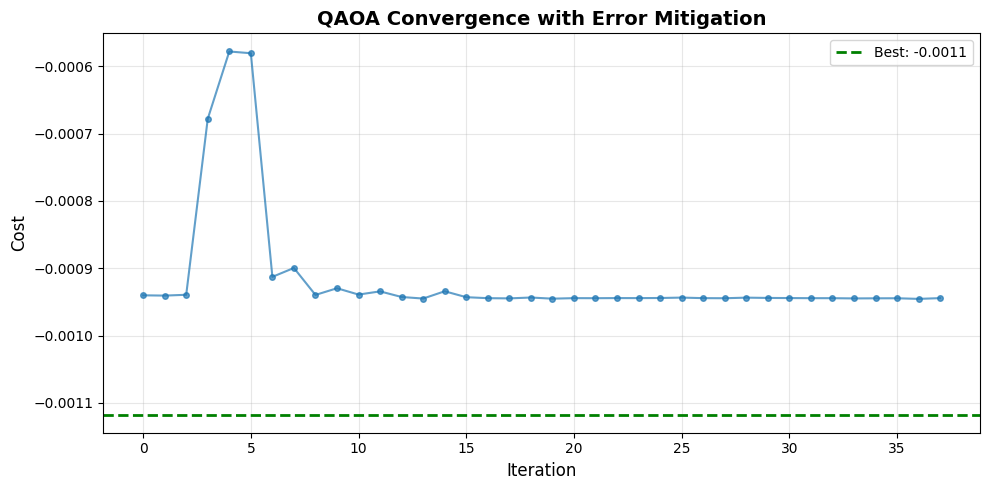


✓ Convergence plot saved


In [14]:
# Compare with brute-force
try:
    bf_data = np.load("bruteforce_results.npz", allow_pickle=True)
    fx_opt = float(bf_data['fx_bruteforce'])
    gap = 100 * (fx_best - fx_opt) / fx_opt
    
    print(f"\n🎯 Comparison to optimal:")
    print(f"  Optimal (brute-force): {fx_opt:.6f}")
    print(f"  QAOA (with mitigation): {fx_best:.6f}")
    print(f"  Gap: {gap:.2f}%")
    
    if gap < 5:
        print("  ✅ Excellent: <5% gap")
    elif gap < 15:
        print("  ✓ Good: <15% gap")
    elif gap < 30:
        print("  ⚠️ Acceptable: <30% gap")
    else:
        print("  ❌ Poor: >30% gap")
except:
    print("\n⚠️ Brute-force results not available for comparison")

# Plot convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cost_history, marker='o', markersize=4, linewidth=1.5, alpha=0.7)
plt.axhline(y=fx_best, color='green', linestyle='--', linewidth=2, label=f'Best: {fx_best:.4f}')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('QAOA Convergence with Error Mitigation', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('qaoa_em_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Convergence plot saved")


In [15]:
np.savez_compressed(
    "qaoa_error_mitigation_results.npz",
    # Solution
    fx_qaoa=fx_best,
    x_qaoa=x_best,
    portfolio=sel_tickers,
    
    # Parameters
    best_theta=best_theta,
    cost_history=cost_history,
    
    # Configuration
    backend=backend.name,
    backend_type="FAKE" if IBM_CONFIG['use_fake_backend'] else "REAL",
    p_layers=P_LAYERS,
    shots=QAOA_CONFIG['shots'],
    final_shots=ADVANCED_CONFIG['final_shots'],
    
    # Error mitigation config
    error_mitigation=ERROR_MITIGATION_CONFIG,
    #resilience_level=ADVANCED_CONFIG['resilience_level'],
    
    # Metrics
    optimization_time=t_opt,
    total_evaluations=result.nfev,
    
    # Financial metrics
    mu_ann=mu_ann,
    std_ann=std_ann,
    sharpe=sharpe
)

print("\\n✓ Results saved to: qaoa_error_mitigation_results.npz")
print(f"  Backend mode: {'🧪 FAKE (Testing)' if IBM_CONFIG['use_fake_backend'] else '☁️ IBM QUANTUM (Real)'}")
print(f"  Total runtime: {t_opt:.1f}s")
print(f"  Techniques used: {sum(ERROR_MITIGATION_CONFIG.values())}/4")

\n✓ Results saved to: qaoa_error_mitigation_results.npz
  Backend mode: 🧪 FAKE (Testing)
  Total runtime: 79.4s
  Techniques used: 2/4
